### Practical Part Assignment 1 [5 points]:

Deadline: 08.02.2024 12:00 (noon)

This assignment is designed to help you become acquainted with the basics of PyTorch (loading in data, training, testing). For those opting to work on personal devices, we encourage you to follow the provided setup instructions accompanying this assignment. Alternatively, Google Colab is also available as a convenient option.

### Instructions: 
1.  [3.5 points]: Please train a maximum likelihood classifier on CIFAR10 and report its out-of-sample (test set) accuracy. You are free to choose any architecture for the classifier; please provide a brief explanation of your choice. Below, you will find some starter code to assist you. If you are new to PyTorch, you might find it beneficial to refer to the tutorials available on the website [https://pytorch.org/tutorials/beginner/basics/intro.html](https://pytorch.org/tutorials/beginner/basics/intro.html).
2. [1.5 points]: Plot your classifier's calibration curve for a selected class vs. the remaining classes treated as a separate class.

### Additional Information:
To help you get a grip on tensor manipulations we uploaded an overview of the dimension and shape operation in PyTorch that we consider most valuable. Additionally, it includes a refresher on the concept of broadcasting. 


In [1]:
"""
We start by importing necessary libraries 

We define transformations for the dataset such as normalization in the context of broadcasting

CIFAR10 dataset is loaded and split into training and testing sets.

A simple Convolutional Neural Network (CNN) architecture is defined using the Net class.
We took a simple template CNN and modified it to be slightly more complex.
We increased the number of channels in the convolutional layers and increased the number of convolutional layers so that  the model can learn more complex features.
By adjusting the size of fully connected layers, we increase the model capacity, allowing it to capture more complex relationships in the data.
Since the spatial dimensions of the feature maps change after the last pooling layer, we need to adjust the input features for the fully connected layer accordingly. 

We define the loss function (CrossEntropyLoss) and optimizer (SGD) for training the network. 
Cross Entropy Loss was listed as one of the most common loss functions for image classification https://towardsdatascience.com/choosing-and-customizing-loss-functions-for-image-processing-a0e4bf665b0a
Stochastic Gradient Descent was chosen because it is one of the most well known optimizers and also listed as a potential candidate on https://medium.com/analytics-vidhya/this-blog-post-aims-at-explaining-the-behavior-of-different-algorithms-for-optimizing-gradient-46159a97a8c1

The network is trained for a few epochs on the training data.

We evaluate the accuracy of the trained model on the test data.

Finally, we plot the calibration curve for class plane versus the remaining classes treated as a separate class using calibration_curve from scikit-learn."""

'\nWe start by importing necessary libraries \n\nWe define transformations for the dataset such as normalization in the context of broadcasting\n\nCIFAR10 dataset is loaded and split into training and testing sets.\n\nA simple Convolutional Neural Network (CNN) architecture is defined using the Net class.\nWe took a simple template CNN and modified it to be slightly more complex.\nWe increased the number of channels in the convolutional layers and increased the number of convolutional layers so that  the model can learn more complex features.\nBy adjusting the size of fully connected layers, we increase the model capacity, allowing it to capture more complex relationships in the data.\nSince the spatial dimensions of the feature maps change after the last pooling layer, we need to adjust the input features for the fully connected layer accordingly. \n\nWe define the loss function (CrossEntropyLoss) and optimizer (SGD) for training the network. \nCross Entropy Loss was listed as one of 

In [2]:
# imports
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.special import softmax
# set a global seed for Reproducibility 
torch.manual_seed(45)

# set system specific variables to make use of available hardware.
num_workers = os.cpu_count()
print('number of workers:', num_workers)

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print('device used:', device)

number of workers: 12
device used: cpu


In [3]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Define a simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [7]:
# Train the network
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.198
[1,  4000] loss: 1.838
[1,  6000] loss: 1.613
[1,  8000] loss: 1.501
[1, 10000] loss: 1.399
[1, 12000] loss: 1.324
[2,  2000] loss: 1.173
[2,  4000] loss: 1.137
[2,  6000] loss: 1.098
[2,  8000] loss: 1.045
[2, 10000] loss: 0.998
[2, 12000] loss: 0.996
[3,  2000] loss: 0.849
[3,  4000] loss: 0.850
[3,  6000] loss: 0.837
[3,  8000] loss: 0.823
[3, 10000] loss: 0.815
[3, 12000] loss: 0.782
[4,  2000] loss: 0.672
[4,  4000] loss: 0.666
[4,  6000] loss: 0.655
[4,  8000] loss: 0.682
[4, 10000] loss: 0.666
[4, 12000] loss: 0.646
Finished Training


In [8]:
# Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 72 %


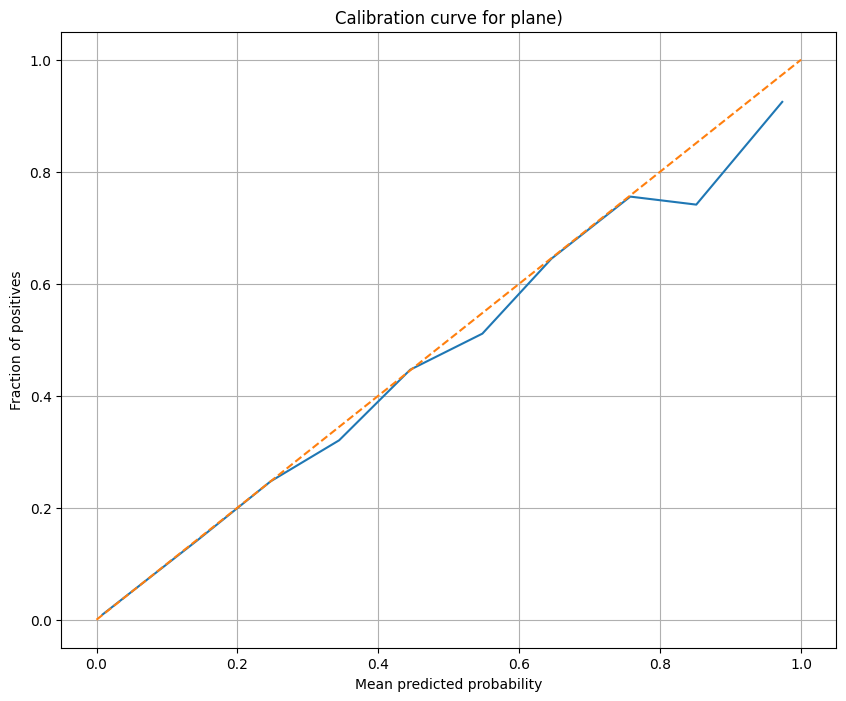

In [14]:
# Plot calibration curve for class 0 (airplane)
outputs = []
labels = []
with torch.no_grad():
    for data in testloader:
        images, target = data
        output = net(images)
        outputs.extend(output.cpu().numpy())
        labels.extend(target.cpu().numpy())

outputs = np.array(outputs)
labels = np.array(labels)

# Choose the class for which you want to plot the calibration curve
selected_class = 0  # You can choose any class from 0 to 9

# Plot calibration curve for the selected class against the rest of the classes
probabilities = softmax(outputs, axis=1)

# Convert labels to binary where 1 represents the selected class and 0 represents all other classes
binary_labels = np.where(labels == selected_class, 1, 0)

# Plot calibration curve for the selected class against all other classes
probability_true, probability_pred = calibration_curve(binary_labels, probabilities[:, selected_class], n_bins=10)
plt.figure(figsize=(10, 8))
plt.plot(probability_pred, probability_true, linestyle='-', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal Calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve for plane)')
plt.grid()
plt.legend()
plt.show()
